# 四、 GCN-节点分类
- 图卷积网络（Graph Convolutional Network​​, GCN）
- 传统神经网络（如CNN）处理图像这种规则网格数据很拿手，但处理像社交网络、分子结构这种不规则的关系图就很吃力。​​GCN就是专门为这种​​非欧几里得数据设计的神经网络​​。
- GCN的关键思想非常直观：​​一个节点的特征，应该由其自身和它邻居节点的特征共同决定​​。因此，每一层GCN都在做这件事：​​收集邻居信息，结合自身信息，更新成更丰富的特征​​。也就是邻居聚合，也叫消息传递。
- 层数代表感受野，GCN的层数决定了节点能获取多远的信息。

Number of nodes: 2708
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 010, Loss: 0.9107, Train: 0.9571, Val: 0.7560, Test: 0.7670
Epoch: 020, Loss: 0.3213, Train: 0.9929, Val: 0.7860, Test: 0.7820
Epoch: 030, Loss: 0.1157, Train: 1.0000, Val: 0.7980, Test: 0.8010
Epoch: 040, Loss: 0.0560, Train: 1.0000, Val: 0.7860, Test: 0.7890
Epoch: 050, Loss: 0.0523, Train: 1.0000, Val: 0.7820, Test: 0.7960
Epoch: 060, Loss: 0.0389, Train: 1.0000, Val: 0.7780, Test: 0.8020
Epoch: 070, Loss: 0.0545, Train: 1.0000, Val: 0.7840, Test: 0.8010
Epoch: 080, Loss: 0.0589, Train: 1.0000, Val: 0.7800, Test: 0.8000
Epoch: 090, Loss: 0.0511, Train: 1.0000, Val: 0.7760, Test: 0.8050
Epoch: 100, Loss: 0.0497, Train: 1.0000, Val: 0.7800, Test: 0.7920
Epoch: 110, Loss: 0.0382, Train: 1.0000, Val: 0.7740, Test: 0.7990
Epoch: 120, Loss: 0.0493, Train: 1.0000, Val: 0.7740, Test: 0.7960
Epoch: 130, Loss: 0.022

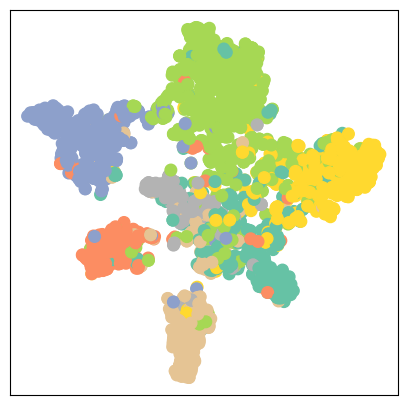

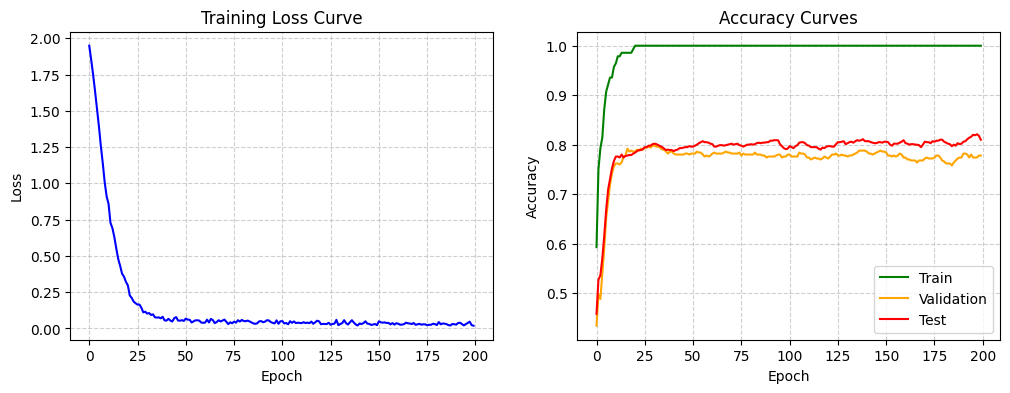


=== Final Results ===
Best Validation Accuracy: 0.7980
Final Train Accuracy: 1.0000
Final Validation Accuracy: 0.7780
Final Test Accuracy: 0.8100


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv  # GCN层
from torch_geometric.datasets import Planetoid  # 加载数据集
import matplotlib.pyplot as plt  # 可视化
from sklearn.manifold import TSNE  # 降维

# 加载Cora数据集
dataset = Planetoid(root='../datasets', name='Cora')
data = dataset[0]

# 检查掩码是否正确加载
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Number of test nodes: {data.test_mask.sum()}")


# GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


# 初始化模型，隐藏层核数是16
model = GCN(num_features=dataset.num_features,
            hidden_channels=16,
            num_classes=dataset.num_classes)
print(model)

# 设置损失函数、优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# 训练函数
def train():
    model.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清空梯度
    out = model(data.x, data.edge_index)  # 前向传播，计算输出
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新参数
    return loss.item()


# 测试函数
def test():
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # 前向传播，计算输出
        results = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = out.argmax(dim=1)  # 选择概率最大的类别作为预测结果
            acc = pred[mask].eq(data.y[mask]).float().mean().item()
            results.append(acc)
    return results


# 训练过程记录
train_losses = []
train_accs = []
val_accs = []
test_accs = []
best_val_acc = 0
best_model_state = None

# 迭代训练
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    # 记录指标
    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), 'output/04-gcn-node.pth')
    
    # 打印训练信息
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


# 降维并可视化
def visualize(h, color, epoch=None, save=False):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


# 分类结果可视化
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# 训练曲线可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train', color='green')
plt.plot(val_accs, label='Validation', color='orange')
plt.plot(test_accs, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 最终评估
model.load_state_dict(best_model_state)
final_train, final_val, final_test = test()

print('=== Final Results ===')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Final Train Accuracy: {final_train:.4f}')
print(f'Final Validation Accuracy: {final_val:.4f}')
print(f'Final Test Accuracy: {final_test:.4f}')